In [3]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch

%matplotlib inline

In [4]:
h2o.__version__

'3.28.0.3'

## Load Dataset

In [5]:
data = pd.read_csv('conversion_data.csv')
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              316200 non-null  object
 1   age                  316200 non-null  int64 
 2   new_user             316200 non-null  int64 
 3   source               316200 non-null  object
 4   total_pages_visited  316200 non-null  int64 
 5   converted            316200 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [7]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [10]:
# Display # of unique values and fisrt 5 uniques values in terms of count of each column
for column in data.columns:
    nuniques = data[column].nunique()
    uniques = data[column].unique()
#     uniques = sorted(data[column].unique())    # sort by unique value itself, not by its count
    print('{0:20s}\t {1:5d}\t\t'.format(column, nuniques), uniques[:5])


country             	     4		 ['UK' 'US' 'China' 'Germany']
age                 	    60		 [25 23 28 39 30]
new_user            	     2		 [1 0]
source              	     3		 ['Ads' 'Seo' 'Direct']
total_pages_visited 	    29		 [1 5 4 6 2]
converted           	     2		 [0 1]


## Remove Outliers
Typically, age should be below 100. So, first let check outliers and clean the dataset

In [11]:
data[data['age'] > 90]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


There are only two records that is invalid, let's first remove them directly

In [12]:
data = data[data['age'] < 100]

In [13]:
data.groupby('converted')['converted'].count()/len(data)

converted
0    0.967748
1    0.032252
Name: converted, dtype: float64

## Exploratory Data Analysis

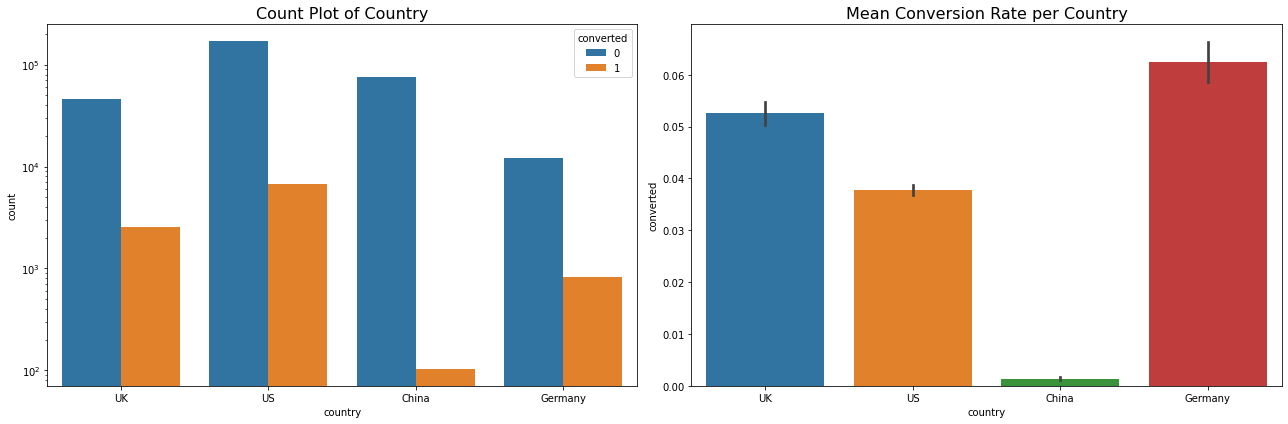

In [14]:
# Visualization of different countries vs. conversion
grouped = data[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

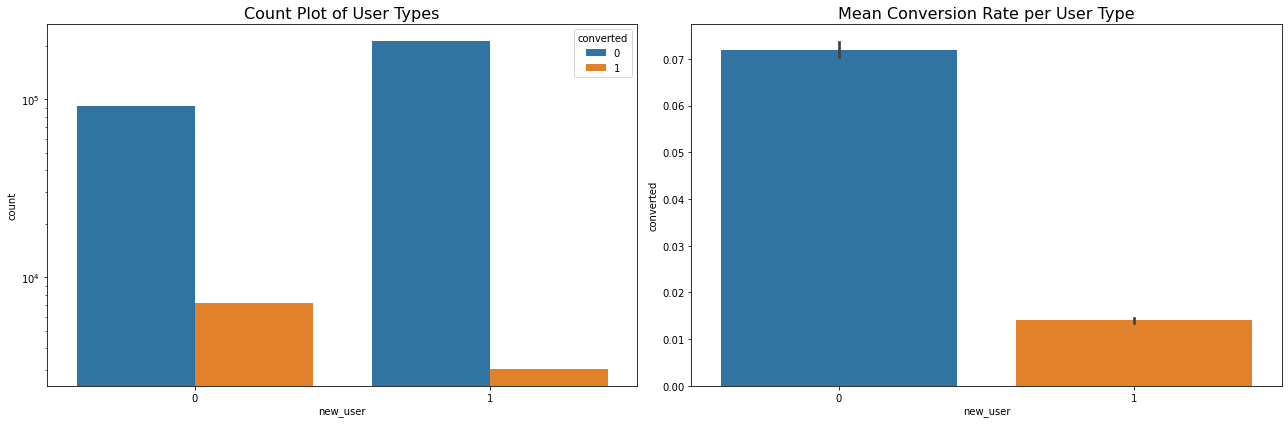

In [75]:
# Visualization of different user types vs. conversion
grouped = data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

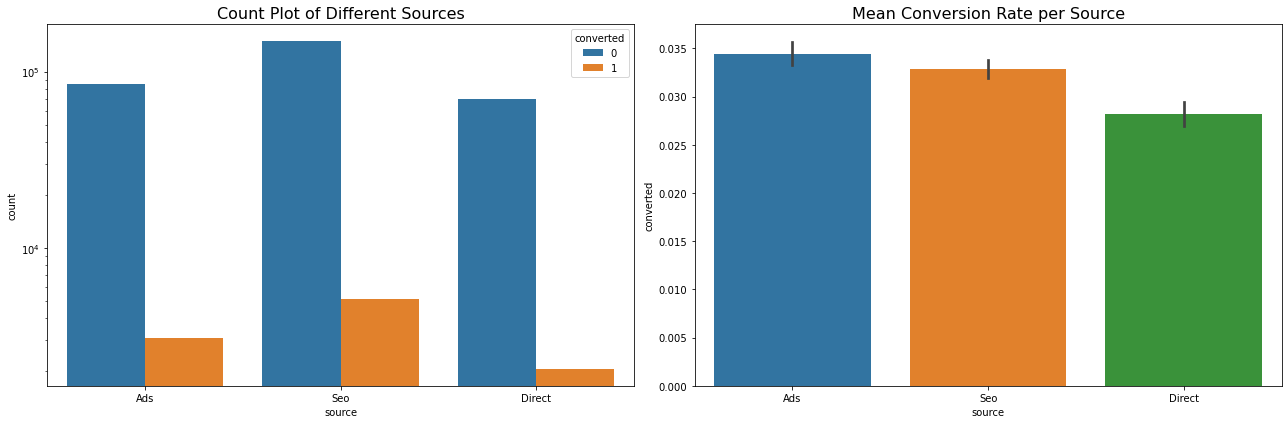

In [76]:
# Visualization of different sources vs. conversion
grouped = data[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=data, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=data, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

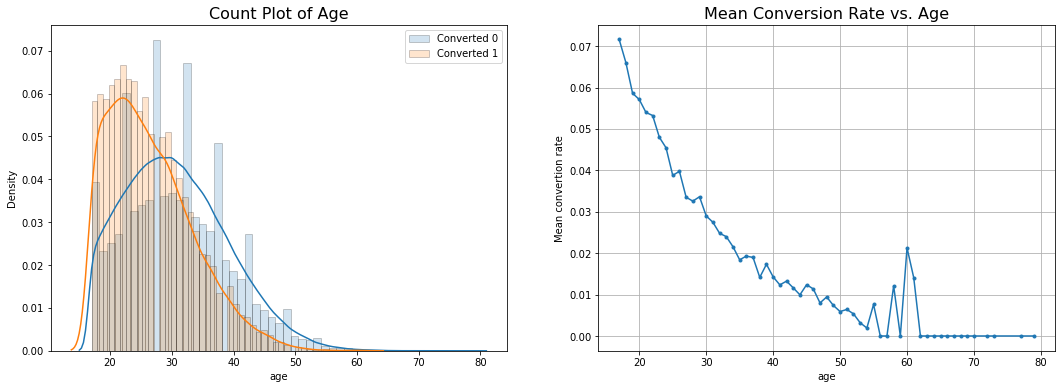

In [78]:
# Visualization of different age vs. conversion
grouped = data[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

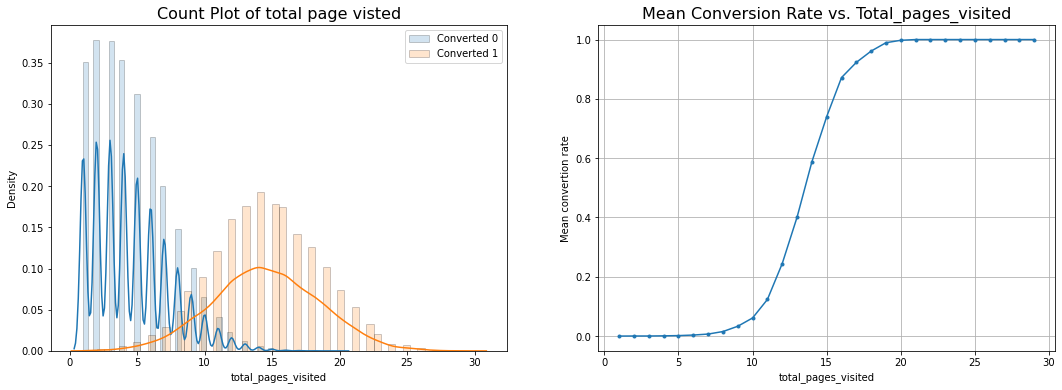

In [12]:
# Visualization of # of total page viewed vs. conversion
grouped = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(data[data['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(data[data['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of total page visted', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

## Machine Learning Model

In [79]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.251-b08, mixed mode)
  Starting server from C:\Users\Vin\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Vin\AppData\Local\Temp\tmpo73abc9x
  JVM stdout: C:\Users\Vin\AppData\Local\Temp\tmpo73abc9x\h2o_Vin_started_from_python.out
  JVM stderr: C:\Users\Vin\AppData\Local\Temp\tmpo73abc9x\h2o_Vin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,8 months and 4 days !!!
H2O cluster name:,H2O_from_python_Vin_tk8zdd
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [81]:
# Transform to H2O Frame, and make sure the target variable is categorical
h2o_df = H2OFrame(data)

h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()

h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.5693110013347,,,4.872918234777034,
maxs,,79.0,,,29.0,
sigma,,8.268957596421474,,,3.3410533442156267,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


In [84]:
# Split into 75% training and 25% test dataset
strat_split = h2o_df['converted'].stratified_split(test_frac=0.25, seed=42)

train = h2o_df[strat_split == 'train']
test = h2o_df[strat_split == 'test']

feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [85]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


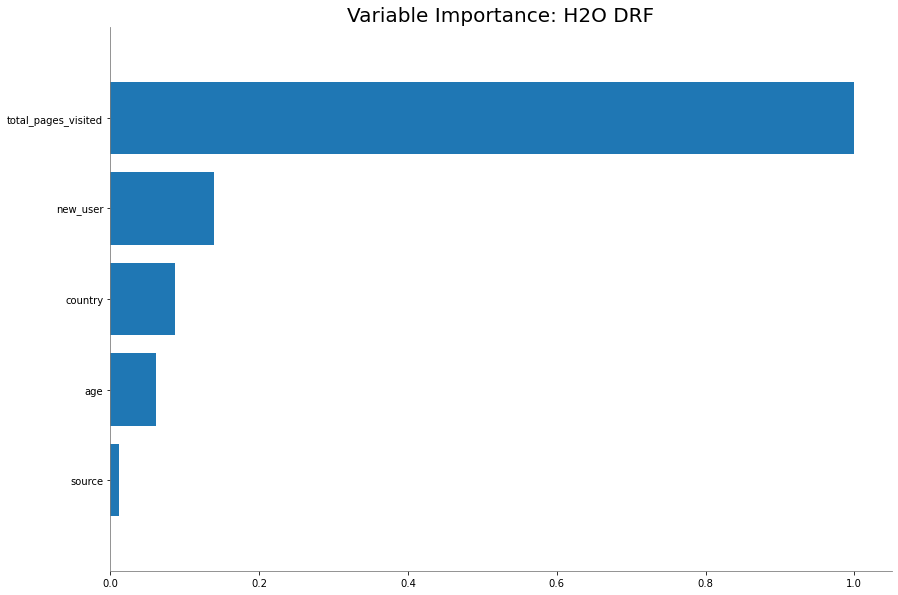

In [86]:
model.varimp_plot()

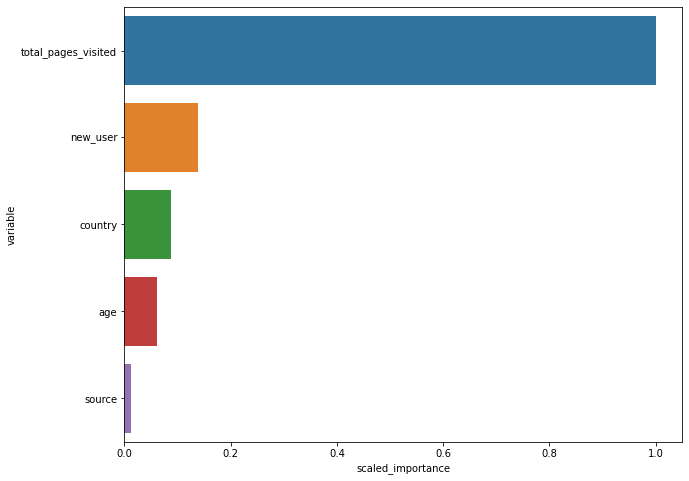

In [87]:
# Feature importance
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [88]:
# Make predictions
train_true = train.as_data_frame()['converted'].values
test_true = test.as_data_frame()['converted'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values

train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)

drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


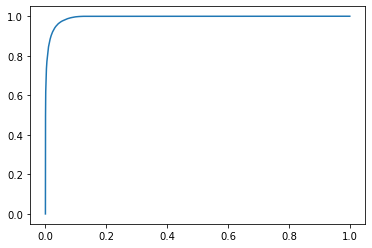

In [90]:
# area under ROC
plt.plot(train_fpr, train_tpr)

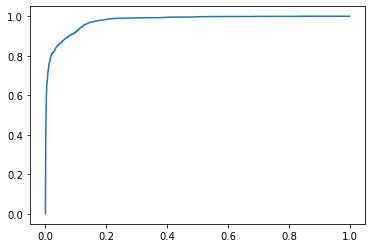

In [91]:
# area under ROC
plt.plot(test_fpr, test_tpr)

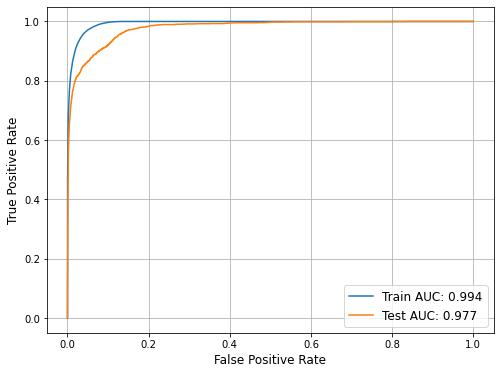

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.grid(which = 'both',axis = 'both')
plt.show()

In [92]:
# Classification report
print(classification_report(y_true=test_true, y_pred=(test_pred > 0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     76500
           1       0.84      0.63      0.72      2550

    accuracy                           0.98     79050
   macro avg       0.91      0.81      0.86     79050
weighted avg       0.98      0.98      0.98     79050



PartialDependencePlot progress: |█████████████████████████████████████████| 100%


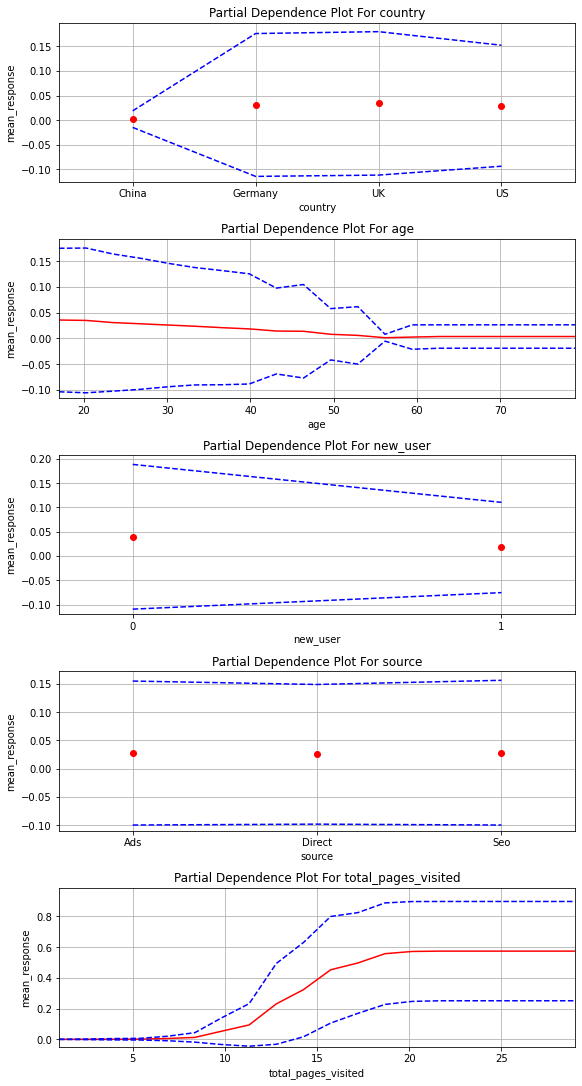

In [23]:
# Partial dependence plot gives a graphical depiction of the marginal effect of a variable on the response. 
# The effect of a variable is measured in change in the mean response. 
_ = model.partial_plot(train, cols=feature, figsize=(8, 15))

In [24]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_9cce closed.


<!-- Future Work -->

## Future Work

### 1. Hyperparameter Tuning with random forest   

### 2. K-Fold Cross Validation to avoid overfitting